In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import optuna

In [2]:
# Устанавливаем глобальное начальное состояние генератора случайных чисел
np.random.seed(42)

In [ ]:
df = pd.read_csv('data/df_ic50_iqr.csv')

In [4]:
# Найдем медиану по столбцу и добавим бинарное значение в датафрейм
median_ic50 = df['IC50'].median()
df['IC50_binary'] = (df['IC50'] > median_ic50).astype(int)

In [5]:
# Проверим баланс классов
df['IC50_binary'].value_counts()

IC50_binary
0    427
1    427
Name: count, dtype: int64

Анализ целевой переменной показал, что классы идеально сбалансированы. Применение методов коррекции не требуется.

In [7]:
# Разделяем данные
X = df.drop(columns=['IC50', 'IC50_binary'])  # Убираем целевую переменную
y = df['IC50_binary']

In [8]:
# Делим исходные данные на тренировочную и тестовую выборки
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2)

Теперь необходимо выбрать оптимальную модель.

Для построения предсказательной модели были рассмотрены следующие алгоритмы:

* XGBClassifier;

* RandomForestClassifier;

* GradientBoostingClassifier;

* CatBoostClassifier;

* HistGradientBoostingClassifier;

* ExtraTreesClassifier.

In [10]:
models = {
    'XGB': XGBClassifier(eval_metric='logloss'),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'HistGradientBoosting': HistGradientBoostingClassifier(),
    'ExtraTrees': ExtraTreesClassifier()
}

In [11]:
def evaluate_models(models, X_train_full, y_train_full, X_test, y_test):
    results = []

    for name, model in models.items():
        pipeline = Pipeline([
            ('classifier', model)
        ])

        pipeline.fit(X_train_full, y_train_full)
        y_pred = pipeline.predict(X_test)

        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.append({
            'Model': name,
            'Accuracy': round(accuracy, 4),
            'ROC_AUC': round(roc_auc, 4) if roc_auc is not None else None,
            'F1': round(f1, 4),
            'Tuned': False
        })

    return pd.DataFrame(results)
results_untuned = evaluate_models(models, X_train_full, y_train_full, X_test, y_test)
display(results_untuned)

,Model,Accuracy,ROC_AUC,F1,Tuned
0,XGB,0.8012,0.8671,0.7875,False
1,RandomForest,0.7485,0.8500,0.7226,False
2,GradientBoosting,0.7895,0.8618,0.7778,False
3,CatBoost,0.7836,0.8654,0.7730,False
4,HistGradientBoosting,0.7953,0.8663,0.7799,False
5,ExtraTrees,0.7193,0.8229,0.6842,False


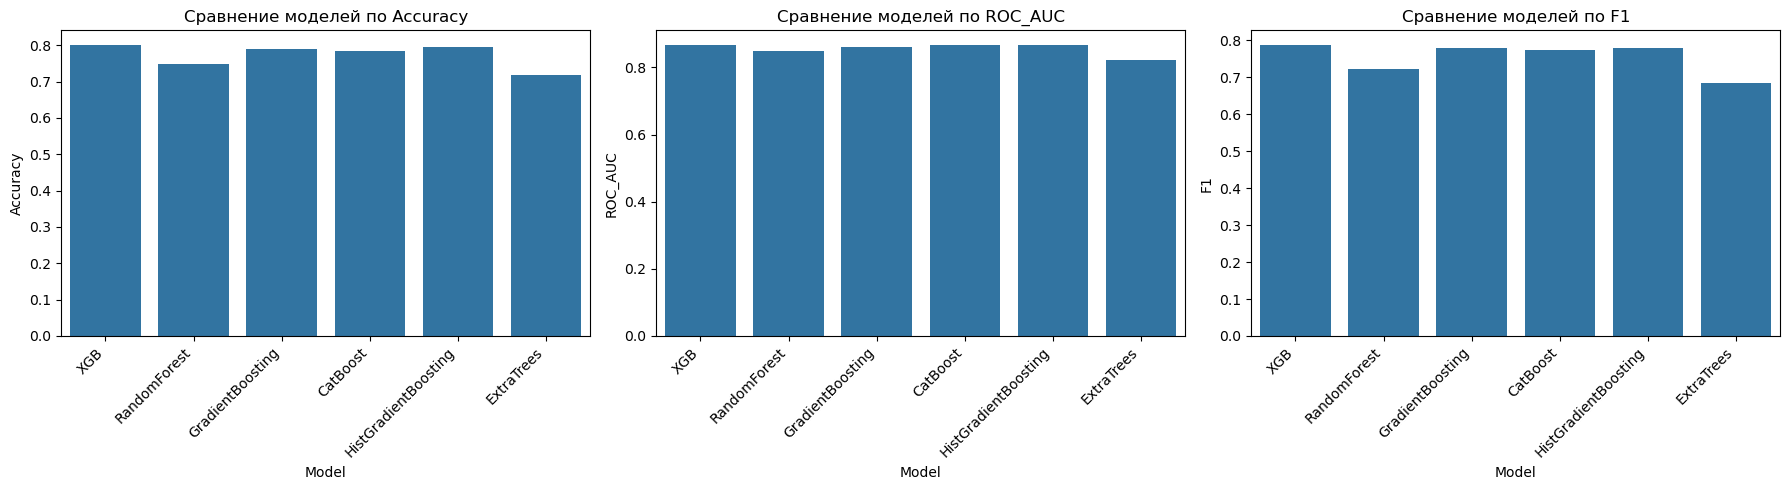

In [12]:
def plot_metrics_comparison(results_df):
    metrics = ['Accuracy', 'ROC_AUC', 'F1']
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, metric in enumerate(metrics):
        sns.barplot(data=results_df, x='Model', y=metric, ax=axs[i])
        axs[i].set_title(f'Сравнение моделей по {metric}')
        axs[i].set_xticks(range(len(results_df['Model'])))
        axs[i].set_xticklabels(results_df['Model'], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

plot_metrics_comparison(results_untuned)

In [ ]:
def optuna_tuning(models, n_trials=50):
    results = []
    trained_models = {}

    # Проходим по всем моделям из переданного словаря
    for model_key, model in models.items():
        # Разбиваем данные на train/validation
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train_full, y_train_full, test_size=0.2, random_state=42
        )

        # Определяем функцию-цель для Optuna
        def objective(trial):
            # Для каждой модели формируем свой словарь параметров
            if model_key == 'XGB':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                    'gamma': trial.suggest_float('gamma', 0, 5),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
                }
                reg = XGBClassifier(**params)

            elif model_key == 'RandomForest':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt', None])
                }
                reg = RandomForestClassifier(**params)

            elif model_key == 'GradientBoosting':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
                }
                reg = GradientBoostingClassifier(**params, random_state=42)

            elif model_key == 'CatBoost':
                params = {
                    'iterations': trial.suggest_int('iterations', 100, 1000),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'depth': trial.suggest_int('depth', 4, 10),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1)
                }
                reg = CatBoostClassifier(**params, verbose=False)

            elif model_key == 'HistGradientBoosting':
                params = {
                    'max_iter': trial.suggest_int('max_iter', 50, 300),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                    'l2_regularization': trial.suggest_float('l2_regularization', 0, 1)
                }
                reg = HistGradientBoostingClassifier(**params)

            elif model_key == 'ExtraTrees':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
                }
                reg = ExtraTreesClassifier(**params)

            # Обучаем на train и проверяем accuracy_score на valid
            reg.fit(X_train, y_train)
            y_pred = reg.predict(X_valid)
            return accuracy_score(y_valid, y_pred)

        # Запускаем оптимизацию Optuna
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)

        # Формируем финальную модель с лучшими гиперпараметрами
        best_params = study.best_params

        if model_key == 'XGB':
            final_model = XGBClassifier(**best_params)

        elif model_key == 'RandomForest':
            final_model = RandomForestClassifier(**best_params)

        elif model_key == 'GradientBoosting':
            final_model = GradientBoostingClassifier(**best_params)

        elif model_key == 'CatBoost':
            final_model = CatBoostClassifier(**best_params, verbose=False)

        elif model_key == 'HistGradientBoosting':
            final_model = HistGradientBoostingClassifier(**best_params)

        elif model_key == 'ExtraTrees':
            final_model = ExtraTreesClassifier(**best_params)

        # Обучаем финальную модель на полном тренировочном наборе
        final_model.fit(X_train_full, y_train_full)

        # Сохраняем обученную модель в словарь trained_models
        trained_models[model_key] = final_model

        # Оцениваем финальную модель на тестовом наборе
        y_test_pred = final_model.predict(X_test)
        y_test_proba = final_model.predict_proba(X_test)[:, 1]
        
        test_f1 = f1_score(y_test, y_test_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_proba)

        # Сохраняем метрики в список results
        results.append({
            'Model': model_key,
            'F1': round(test_f1, 4),
            'Accuracy': round(test_accuracy, 4),
            'ROC_AUC': round(test_roc_auc, 4),
            'Tuned': True
        })

    # Превращаем список результатов в DataFrame
    results_tuned = pd.DataFrame(results)

    # Возвращаем две структуры: DataFrame и словарь обученных моделей
    return results_tuned, trained_models

In [14]:
results_tuned, trained_models = optuna_tuning(models)

[I 2025-06-02 20:02:25,875] A new study created in memory with name: no-name-1573df4d-2242-47da-9e0c-7a7cca14a603
[I 2025-06-02 20:02:26,601] Trial 0 finished with value: 0.7372262773722628 and parameters: {'n_estimators': 359, 'max_depth': 5, 'learning_rate': 0.026266441657989505, 'subsample': 0.842799097176038, 'colsample_bytree': 0.9293522629843478, 'gamma': 0.4451245071398041, 'min_child_weight': 9}. Best is trial 0 with value: 0.7372262773722628.
[I 2025-06-02 20:02:26,795] Trial 1 finished with value: 0.7518248175182481 and parameters: {'n_estimators': 203, 'max_depth': 9, 'learning_rate': 0.14717692426672307, 'subsample': 0.9255349062712481, 'colsample_bytree': 0.7219604297820661, 'gamma': 2.2454068230848563, 'min_child_weight': 9}. Best is trial 1 with value: 0.7518248175182481.
[I 2025-06-02 20:02:27,311] Trial 2 finished with value: 0.7518248175182481 and parameters: {'n_estimators': 96, 'max_depth': 9, 'learning_rate': 0.02992580192690801, 'subsample': 0.7591675011762845, 'c

In [15]:
results_tuned

,Model,F1,Accuracy,ROC_AUC,Tuned
0,XGB,0.7826,0.7953,0.8656,True
1,RandomForest,0.7389,0.7602,0.8460,True
2,GradientBoosting,0.7636,0.7719,0.8546,True
3,CatBoost,0.7799,0.7953,0.8661,True
4,HistGradientBoosting,0.7702,0.7836,0.8550,True
5,ExtraTrees,0.7368,0.7661,0.8637,True


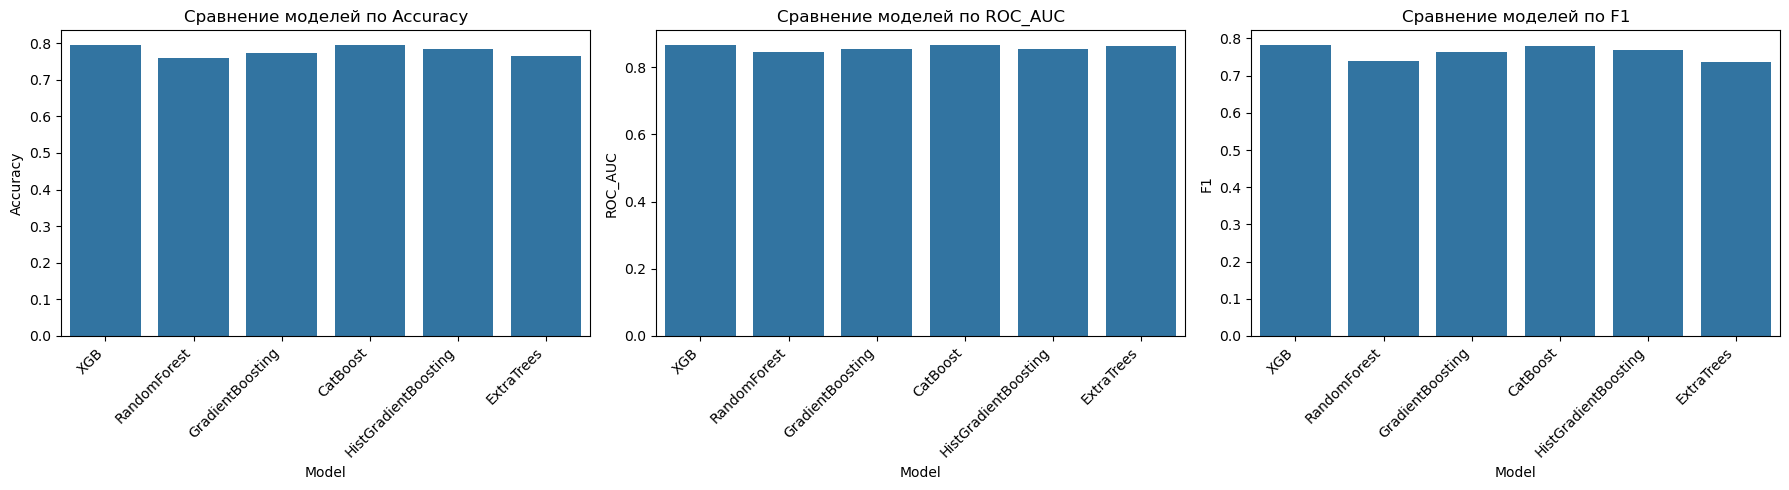

In [16]:
plot_metrics_comparison(results_tuned)

In [17]:
combined_results = pd.concat([results_untuned, results_tuned], ignore_index=True)
display(combined_results.sort_values(by=["Accuracy"], ascending=False))

,Model,Accuracy,ROC_AUC,F1,Tuned
0,XGB,0.8012,0.8671,0.7875,False
9,CatBoost,0.7953,0.8661,0.7799,True
6,XGB,0.7953,0.8656,0.7826,True
4,HistGradientBoosting,0.7953,0.8663,0.7799,False
2,GradientBoosting,0.7895,0.8618,0.7778,False
3,CatBoost,0.7836,0.8654,0.7730,False
10,HistGradientBoosting,0.7836,0.8550,0.7702,True
8,GradientBoosting,0.7719,0.8546,0.7636,True
11,ExtraTrees,0.7661,0.8637,0.7368,True
7,RandomForest,0.7602,0.8460,0.7389,True


<Figure size 1500x500 with 0 Axes>

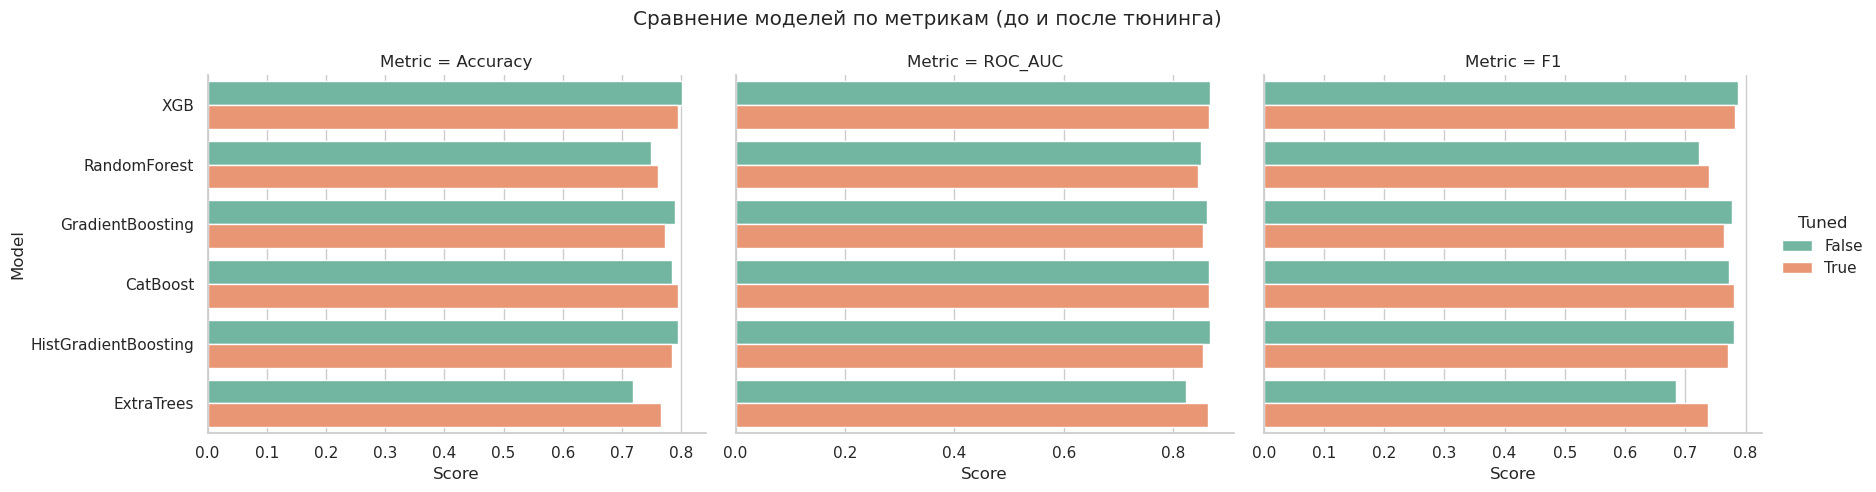

In [18]:
def plot_all_metrics(combined_results):
    melted = combined_results.melt(
        id_vars=["Model", "Tuned"],
        value_vars=['Accuracy', 'ROC_AUC', 'F1'],
        var_name="Metric",
        value_name="Score"
    )

    plt.figure(figsize=(15, 5))
    sns.set(style="whitegrid")

    g = sns.catplot(
        data=melted,
        x="Score",
        y="Model",
        hue="Tuned",
        col="Metric",
        kind="bar",
        palette="Set2",
        sharex=False,
        height=5,
        aspect=1.2
    )

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle("Сравнение моделей по метрикам (до и после тюнинга)")
    plt.show()
plot_all_metrics(combined_results)